# Imports

In [1]:
import pandas as pd
import numpy as np
import re
import string
import json
import os
import pickle

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

from langdetect import detect
import spacy

import nltk
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,\
classification_report, accuracy_score, precision_score

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,\
HashingVectorizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from xgboost import XGBClassifier

import pendulum

In [2]:
def confusion_matrix_plot(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    return plt.show()

def report(y_true, y_pred, class_names=['no_spoiler', 'spoiler']):
    print(classification_report(y_true, y_pred, target_names=class_names))
    confusion_matrix_plot(y_true, y_pred, class_names)
    
sw = stopwords.words('english')
pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
tokenizer = RegexpTokenizer(r"([a-zA-Z]+(?:[’'][a-z]+)?)")
lemmatizer = nltk.stem.WordNetLemmatizer()

# helper function to correctly format the part of speech
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
# helper function to clean and lemmatize the review
def lem_review(df):
    # get the doc text
    doc = df.review_text
    # tokenize the doc, lowercase all words and remove stopwords
    doc = tokenizer.tokenize(doc)
    doc = [token.lower() for token in doc]
    doc = [token for token in doc if token not in sw]
    # tag part of speach and convert format of tagging
    doc_tagged = pos_tag(doc)
    doc_tagged = [(token[0], get_wordnet_pos(token[1])) for token in doc_tagged]
    # lemmatize the doc
    doc_lemmed = [lemmatizer.lemmatize(token[0], token[1]) for token in doc_tagged]
    # join the lemmas together as a string
    doc_cleaned = ' '.join(doc_lemmed)
    # return the cleaned doc
    return doc_cleaned

# helper function to clean and lemmatize the synopsis
def lem_synopsis(df):
    # get the doc text
    doc = df.plot_synopsis
    # tokenize the doc, lowercase all words and remove stopwords
    doc = tokenizer.tokenize(doc)
    doc = [token.lower() for token in doc]
    doc = [token for token in doc if token not in sw]
    # tag part of speach and convert format of tagging
    doc_tagged = pos_tag(doc)
    doc_tagged = [(token[0], get_wordnet_pos(token[1])) for token in doc_tagged]
    # lemmatize the doc
    doc_lemmed = [lemmatizer.lemmatize(token[0], token[1]) for token in doc_tagged]
    # join the lemmas together as a string
    doc_cleaned = ' '.join(doc_lemmed)
    # return the cleaned doc
    return doc_cleaned

# Load Data

In [3]:
# movie_details = pd.read_json('./data/IMDB_movie_details.json', lines=True)

# # fix the movie_id column, some values have trailing forward slashes
# def fix_movie_id(df):
#     if df.movie_id[-1] == '/':
#         return  df.movie_id[:-1]
#     else:
#         return df.movie_id
# movie_details['movie_id'] = movie_details.apply(fix_movie_id, axis=1)

# # load the saved list of ids with no synopsis
# with open('no_synopsis_ids.pkl', 'rb') as f:
#     no_synopsis_ids = pickle.load(f)
    
# # save a new dataframe of just the synopses for the films
# synopsis_df = movie_details[~movie_details.movie_id.isin(no_synopsis_ids)][['movie_id', 'plot_synopsis']].copy()

# # lemmatizing the synopses. this takes about a minute and a half
# synopsis_df['plot_synopsis_lemmed'] = synopsis_df.apply(lem_synopsis, axis=1)

# # saving the synopsis dataframe to save time processing later
# synopsis_df.to_parquet('./data/plot_synopsis_lemmed.parquet')

# # loading the synopsis dataframe, contains both original and lemmed field
# synopsis_df = pd.read_parquet('./data/plot_synopsis_lemmed.parquet')

# # loading the reviews, contains both original and lemmed field
# review_df = pd.read_parquet('./data/reviews_lemmed.parquet')

# # opening the file containing the indices of non-english reviews
# with open('non_english_reviews.pkl', 'rb') as f:
#     non_english_reviews = pickle.load(f)

# # dropping non english reviews
# review_df.drop(non_english_reviews, axis=0, inplace=True)
# review_df.reset_index(drop=True, inplace=True)

# # combine the dataframes, save to parquet file
# large_df = pd.merge(review_df, synopsis_df, on='movie_id', how='right')
# large_df.to_parquet('./data/reviews_synopsis_lemmed.parquet')

In [3]:
large_df = pd.read_parquet('./data/reviews_synopsis_lemmed.parquet', columns=['movie_id',
                                                                              'is_spoiler',
                                                                              'review_text_lemmed',
                                                                              'plot_synopsis_lemmed'])

## train/val/test split

In [4]:
# set X to the review text lemmed, y to target
X = large_df.review_text_lemmed
y = large_df.is_spoiler

# We want 10% of our data for test and 10% for validation, generate our holdout number
holdout = round(len(X) * 0.1)

# do first train/test split for train/val set and test set
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, random_state=42, test_size=holdout)

# perform 2nd train/test split (on train/val) for train and val sets
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, random_state=42, test_size=holdout)

# delete the X, y and trainval variables (no longer needed)
del X, y, X_trainval, y_trainval

# confirm shapes
print(f"X_train / y_train shapes: {X_train.shape}, {y_train.shape}")
print(f"X_val / y_val shapes: {X_val.shape}, {y_val.shape}")
print(f"X_test / y_test shapes: {X_test.shape}, {y_test.shape}")

X_train / y_train shapes: (431026,), (431026,)
X_val / y_val shapes: (53878,), (53878,)
X_test / y_test shapes: (53878,), (53878,)


In [5]:
del large_df

# Baseline Model

In [8]:
# make a baseline dataframe with just the target and the review_text
baseline_df = large_df[['is_spoiler', 'review_text_lemmed']].copy()

# create a new boolean value for reviews that contain the word 'spoiler'
baseline_df['contains_spoiler'] = baseline_df.review_text_lemmed.str.contains('spoiler')
baseline_df['contains_spoiler'] = baseline_df.contains_spoiler.astype(int)

              precision    recall  f1-score   support

  no_spoiler       0.76      0.98      0.85    395686
     spoiler       0.72      0.13      0.22    143096

    accuracy                           0.75    538782
   macro avg       0.74      0.55      0.54    538782
weighted avg       0.75      0.75      0.68    538782



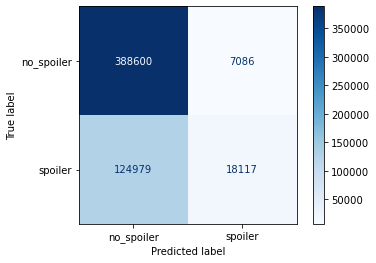

In [9]:
report(baseline_df.is_spoiler, baseline_df.contains_spoiler)

# Bag of Words

In [6]:
# helper function to transform the training and validation data
def transformX(vectorizer, train=X_train, val=X_val, train_target=y_train, val_target=y_val):
    # fit/transform training data
    train_vec = vectorizer.fit_transform(train)
    train_vec = pd.DataFrame.sparse.from_spmatrix(train_vec)
    train_vec.columns = sorted(vectorizer.vocabulary_)
    train_vec.set_index(train_target.index, inplace=True)
    # transform validation data
    val_vec = vectorizer.transform(val)
    val_vec = pd.DataFrame.sparse.from_spmatrix(val_vec)
    val_vec.columns = sorted(vectorizer.vocabulary_)
    val_vec.set_index(val_target.index, inplace=True)
    # return both dataframes
    return train_vec, val_vec

def test_models(vectorizer):
    
    # transfrom X_train and X_val with helper function
    X_train_tfidf, X_val_tfidf = transformX(vectorizer)
    
    # helper function to make fitting, predicting and reporting easier
    def fitpredreport(model):
        model.fit(X_train_tfidf, y_train)
        y_pred = model.predict(X_val_tfidf)
        report(y_val, y_pred)
    
    nb = MultinomialNB()
    lr = LogisticRegression(verbose=1, solver='liblinear', random_state=42, C=5, max_iter=1000)
    svm = LinearSVC(random_state=42)
    
    print('Multinomial Naive Bayes')
    fitpredreport(nb)
    print('--------------------------------------------')
    print('Logistic Regression')
    fitpredreport(lr)
    print('--------------------------------------------')
    print('Support Vector')
    fitpredreport(svm)

## base tfidf vectorizer

Vectorizing with no parameter changes. Takes about 3 minutes and generates a vocabulary of 221,997

Multinomial Naive Bayes
              precision    recall  f1-score   support

  no_spoiler       0.74      1.00      0.85     39720
     spoiler       0.76      0.02      0.05     14158

    accuracy                           0.74     53878
   macro avg       0.75      0.51      0.45     53878
weighted avg       0.75      0.74      0.64     53878



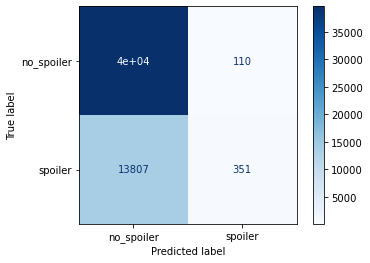

--------------------------------------------
Logistic Regression
[LibLinear]              precision    recall  f1-score   support

  no_spoiler       0.80      0.92      0.86     39720
     spoiler       0.62      0.36      0.46     14158

    accuracy                           0.77     53878
   macro avg       0.71      0.64      0.66     53878
weighted avg       0.75      0.77      0.75     53878



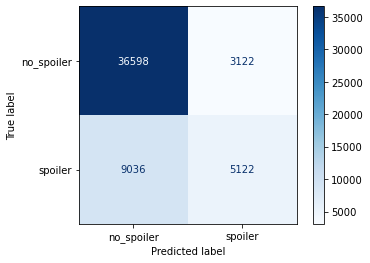

--------------------------------------------
Support Vector
              precision    recall  f1-score   support

  no_spoiler       0.80      0.92      0.86     39720
     spoiler       0.62      0.35      0.45     14158

    accuracy                           0.77     53878
   macro avg       0.71      0.64      0.65     53878
weighted avg       0.75      0.77      0.75     53878



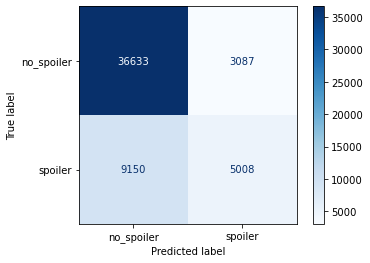

In [8]:
base_tfidf = TfidfVectorizer()

test_models(base_tfidf)

              precision    recall  f1-score   support

  no_spoiler       0.74      1.00      0.85     39720
     spoiler       1.00      0.00      0.00     14158

    accuracy                           0.74     53878
   macro avg       0.87      0.50      0.43     53878
weighted avg       0.81      0.74      0.63     53878



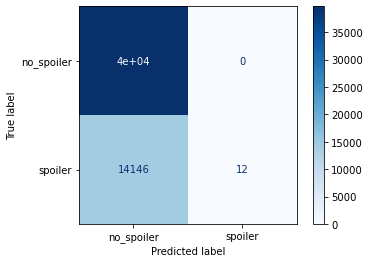

In [12]:
# set tfidf vectorizer, default parameters
base_tfidf = TfidfVectorizer()

X_train_tfidf, X_val_tfidf = transformX(base_tfidf)

# helper function to make fitting, predicting and reporting easier
def fitpredreport(model):
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_val_tfidf)
    report(y_val, y_pred)

# instantiate random forest classifier
rf_v1 = RandomForestClassifier(max_depth=20, random_state=42, n_jobs=-1)
# fit, predict and report with helper function
fitpredreport(rf_v1)

In [15]:
xgb_v1 = XGBClassifier(random_state=42, n_jobs=-1)
fitpredreport(xgb_v1)

MemoryError: Unable to allocate 713. GiB for an array with shape (221997, 431026) and data type float64

## tfidf vectorizer, min 7

Vectorizing with min_df of 7. Takes about two minutes and generates a vocabulary of 54,631

Multinomial Naive Bayes
              precision    recall  f1-score   support

  no_spoiler       0.76      0.98      0.85     39720
     spoiler       0.66      0.11      0.19     14158

    accuracy                           0.75     53878
   macro avg       0.71      0.55      0.52     53878
weighted avg       0.73      0.75      0.68     53878



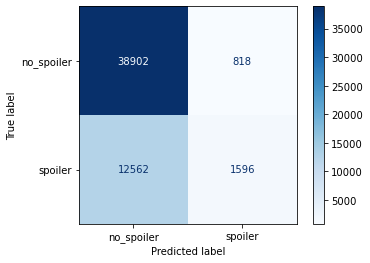

--------------------------------------------
Logistic Regression
[LibLinear]              precision    recall  f1-score   support

  no_spoiler       0.80      0.92      0.86     39720
     spoiler       0.62      0.36      0.45     14158

    accuracy                           0.77     53878
   macro avg       0.71      0.64      0.66     53878
weighted avg       0.75      0.77      0.75     53878



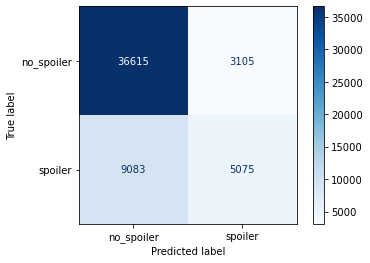

--------------------------------------------
Support Vector
              precision    recall  f1-score   support

  no_spoiler       0.80      0.92      0.86     39720
     spoiler       0.62      0.35      0.45     14158

    accuracy                           0.77     53878
   macro avg       0.71      0.64      0.65     53878
weighted avg       0.75      0.77      0.75     53878



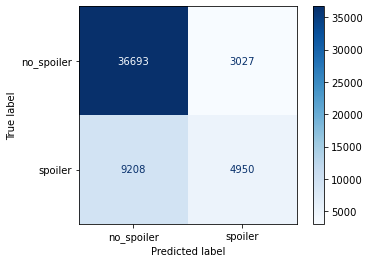

In [7]:
tfidf_min_seven = TfidfVectorizer(min_df=7)

test_models(tfidf_min_seven)

## tfidf vectorizer, min 7 adding bigrams

Vectorizing with bigrams and a min_df of 7. Takes about 11 minutes and generates a vocabulary of 1,056,419

Multinomial Naive Bayes
              precision    recall  f1-score   support

  no_spoiler       0.74      1.00      0.85     39720
     spoiler       0.81      0.02      0.05     14158

    accuracy                           0.74     53878
   macro avg       0.78      0.51      0.45     53878
weighted avg       0.76      0.74      0.64     53878



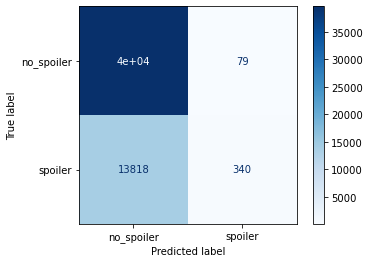

--------------------------------------------
Logistic Regression
[LibLinear]              precision    recall  f1-score   support

  no_spoiler       0.81      0.92      0.86     39720
     spoiler       0.63      0.38      0.47     14158

    accuracy                           0.78     53878
   macro avg       0.72      0.65      0.67     53878
weighted avg       0.76      0.78      0.76     53878



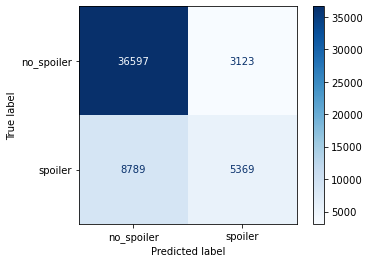

--------------------------------------------
Support Vector
              precision    recall  f1-score   support

  no_spoiler       0.81      0.90      0.85     39720
     spoiler       0.59      0.39      0.47     14158

    accuracy                           0.77     53878
   macro avg       0.70      0.65      0.66     53878
weighted avg       0.75      0.77      0.75     53878



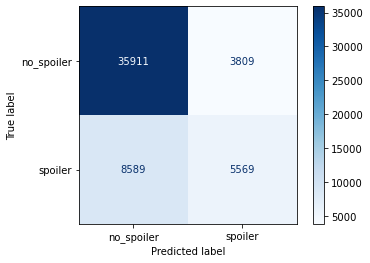

In [10]:
tfidf_min_seven_bi = TfidfVectorizer(min_df=7, ngram_range=(1,2))

test_models(tfidf_min_seven_bi)

## tfidf vectorizer, min 7 adding trigrams

Vectorizing with trigrams and a min_df of 7. Takes about _______ and generates a vocabulary of _______

Multinomial Naive Bayes
              precision    recall  f1-score   support

  no_spoiler       0.74      1.00      0.85     39720
     spoiler       0.82      0.01      0.03     14158

    accuracy                           0.74     53878
   macro avg       0.78      0.51      0.44     53878
weighted avg       0.76      0.74      0.63     53878



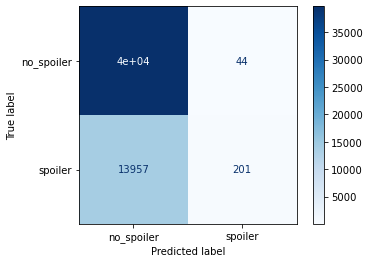

--------------------------------------------
Logistic Regression
[LibLinear]              precision    recall  f1-score   support

  no_spoiler       0.81      0.92      0.86     39720
     spoiler       0.64      0.38      0.47     14158

    accuracy                           0.78     53878
   macro avg       0.72      0.65      0.67     53878
weighted avg       0.76      0.78      0.76     53878



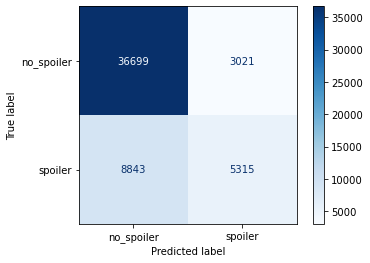

--------------------------------------------
Support Vector
              precision    recall  f1-score   support

  no_spoiler       0.81      0.91      0.85     39720
     spoiler       0.60      0.39      0.47     14158

    accuracy                           0.77     53878
   macro avg       0.70      0.65      0.66     53878
weighted avg       0.75      0.77      0.75     53878



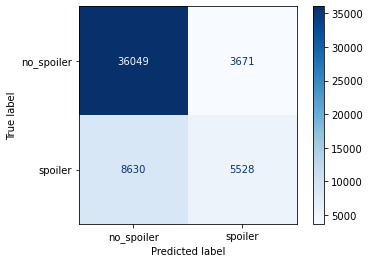

In [12]:
tfidf_min_seven_tri = TfidfVectorizer(min_df=7, ngram_range=(1,3))

test_models(tfidf_min_seven_tri)

# Cosine Similarity

Create a corpus of all the review text and the text of the synopsis of each film

Fit/transform the corpus

Transform the reviews and the synopsis

# BERT